In [1]:
#Haar Cascade

#Buat fungsi bernama haar yang berisi perintah untuk melakukan deteksi wajah dari input berupa citra.
import cv2
import matplotlib.pyplot as plt
import os
def haar(img):
    face_roi = []
    status = False  

    # Load Haar Cascade classifier for face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')  

    # Convert the image to grayscale (required for face detection)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image using the face_cascade
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.5, minNeighbors=5)  

    # Draw bounding boxes around the detected faces and display the image
    for (x, y, w, h) in faces:
        # Draw a rectangle around the detected face
        face_roi = img[y:y+h, x:x+w]
        status = True
    return status,face_roi

 jumlah keypoint terbentuk 53


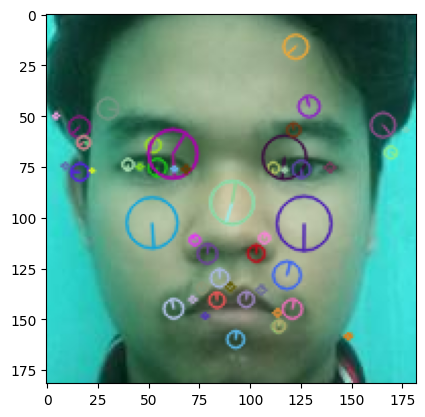

In [2]:
#Scale Invariant Feature Transform
#Deteksi Fitur menggunakan algoritma SIFT.

import cv2
import matplotlib.pyplot as plt

# Loading the image
img = cv2.imread('dataset_wajah/izul/izul (1).jpg')
status,haarnya=haar(img)  

# Applying SIFT detector
sift = cv2.SIFT_create(500)
kpts, des = sift.detectAndCompute(haarnya, None)  

# Marking the keypoint on the image using circles
img=cv2.drawKeypoints(haarnya, kpts , haarnya ,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
print(f" jumlah keypoint terbentuk {len(kpts)}")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [3]:
#Bag of Visual Word

import numpy as np
#kmeans works only on float, so convert integers to float
descriptors_float = des.astype(float)  

# Perform k-means clustering and vector quantization

from scipy.cluster.vq import kmeans, vq
k = 50  #dari total 500 diambil hanya 200
voc, variance = kmeans(obs=descriptors_float, k_or_guess=k, iter=5) 


# Calculate the histogram of features and represent them as vector
#vq Assigns codes from a code book to observations.
im_features = np.zeros((1, k), "float32")
for i in range(1):
    words, distance = vq(des,voc)
    for w in words:
        im_features[i][w] += 1
print(im_features.shape)
print(im_features)

(1, 50)
[[1. 1. 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1.]]


In [4]:
#Feature Extraction
#SIFT

#menentukan direktori/folder data citra yang akan dibuka
dirname = 'dataset_wajah/'  

#menentukan ukuran tinggi dan lebar gambar
height = 225
width = 225
dim = (width, height)

#BRISK is a good replacement to SIFT. ORB also works but didn;t work well for this example  
sift = cv2.SIFT_create()
#mengumpulkan data citra yang akan dibuka dalam satu array
tampungan_data = [] 
tampungan_label = []
for path, subdirs, files in os.walk(dirname):
    print(path)
    for name in files:
        img_path = (os.path.join(path, name))  #baca path data
        if (img_path.endswith("jpg")): #dengan file berekstensi jpg
            img = cv2.imread(img_path) #baca gambar
            status, haarnya = haar(img)
            if(status):
                resized=cv2.resize(haarnya,dim, interpolation=cv2.INTER_LINEAR) #resize
                kpts, des = sift.detectAndCompute(resized, None)
                tampungan_data.append(des)
                
                path_parts = path.split('/')
                # Mengambil elemen terakhir dari path_parts sebagai kata terakhir
                last_word = path_parts[-1]
                #preprocessing data / segentasi  boleh dilakukan disini
                tampungan_label.append(last_word)
    X = np.array(tampungan_data, dtype=object) 
    y = np.array(tampungan_label) 

dataset_wajah/
dataset_wajah/farrel
dataset_wajah/izul
dataset_wajah/rano


In [5]:
#Bag of Visual Word

descriptors = None
for descriptor in X:
    if descriptors is None:
        descriptors = descriptor
    else:
        descriptors = np.vstack((descriptors, descriptor)) #gunakan untuk menggabungkan deskriptor menjadi satu tumpukan

#kmeans works only on float, so convert integers to float
descriptors_float = descriptors.astype(float)  
# Perform k-means clustering and vector quantization
from scipy.cluster.vq import kmeans, vq

k = 70  #k means with 100 clusters gives lower accuracy for the aeroplane example
voc, variance = kmeans(obs=descriptors_float, k_or_guess=k, iter=5) 

# Calculate the histogram of features and represent them as vector
# vq Assigns codes from a code book to observations.
im_features = np.zeros((len(y), k), "float32")
for i in range(len(y)):
    words, distance = vq(X[i],voc)
    for w in words:
        im_features[i][w] += 1
print(im_features.shape)

(107, 70)


{'farrel': 0, 'izul': 1, 'rano': 2} jumlah data: 107


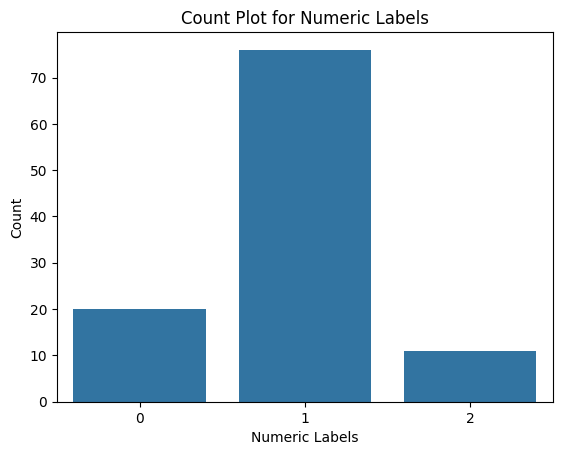

In [6]:
#mendapatkan label unik dan menyimpannya
import seaborn as sns
import matplotlib.pyplot as plt

list_label=np.unique(y) #mendapatkan label unik
label_dict = {label: idx for idx, label in enumerate(list_label)} #masukkan dalam list
print(f"{label_dict} jumlah data: {len(y)}")

label_numerik = [label_dict[s] for s in y] #ubah kedalam numerik
label_numerik_array = np.array(label_numerik)

# Visualisasikan dalam jumlah dalam plot
sns.countplot(x=label_numerik_array)
plt.xlabel('Numeric Labels')
plt.ylabel('Count')
plt.title('Count Plot for Numeric Labels')
plt.show()  

# simpan dalam file npy untuk labeling
np.save('weight/label_knn.npy', label_dict)  

In [7]:
#Train Test Split Data

from sklearn.model_selection import train_test_split #library untuk train test split

#melakukan splitting data
X_train, X_test, y_train, y_test = train_test_split(im_features, label_numerik_array,test_size=0.10, stratify=label_numerik_array) 
#train size adalah persentase data test yang di-split dengan proporsi label yang sama

print("X_train: "+str(X_train.shape))
print("X_test: "+str(X_test.shape))
print("y_train: "+str(y_train.shape))
print("y_test: "+str(y_test.shape))

X_train: (96, 70)
X_test: (11, 70)
y_train: (96,)
y_test: (11,)


In [8]:
#Melatih model knn untuk melakukan klasifikasi 

from sklearn.model_selection import GridSearchCV,StratifiedKFold #melakukan validasi dengan hasil skor akurasi dengan cross validation
parameters = {'n_neighbors':[1, 3, 5, 7],
             'metric': ['minkowski','euclidean','manhattan']} #masukan parameter yang akan dilakukan

from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()

# Create the StratifiedKFold cross-validation method
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


clf = GridSearchCV(model, parameters, verbose=3, cv=stratified_kfold, scoring='accuracy') #panggil gridsearch
clf.fit(X_train,y_train) #train data
best = clf.best_estimator_ #model terbaik
print(clf.best_estimator_) #model terbaik
print(clf.best_score_) #akurasi terbaik

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END ...metric=minkowski, n_neighbors=1;, score=0.969 total time=   0.1s
[CV 2/3] END ...metric=minkowski, n_neighbors=1;, score=1.000 total time=   0.0s
[CV 3/3] END ...metric=minkowski, n_neighbors=1;, score=0.938 total time=   0.0s
[CV 1/3] END ...metric=minkowski, n_neighbors=3;, score=0.938 total time=   0.0s
[CV 2/3] END ...metric=minkowski, n_neighbors=3;, score=0.969 total time=   0.0s
[CV 3/3] END ...metric=minkowski, n_neighbors=3;, score=0.969 total time=   0.0s
[CV 1/3] END ...metric=minkowski, n_neighbors=5;, score=0.938 total time=   0.0s
[CV 2/3] END ...metric=minkowski, n_neighbors=5;, score=0.969 total time=   0.0s
[CV 3/3] END ...metric=minkowski, n_neighbors=5;, score=0.938 total time=   0.0s
[CV 1/3] END ...metric=minkowski, n_neighbors=7;, score=0.969 total time=   0.0s
[CV 2/3] END ...metric=minkowski, n_neighbors=7;, score=0.938 total time=   0.0s
[CV 3/3] END ...metric=minkowski, n_neighbors=7;

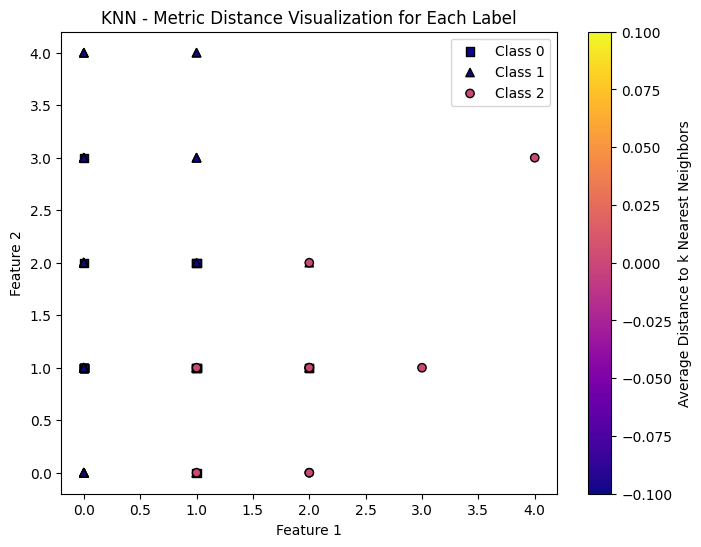

In [9]:
#Visualisasi Matrix Distance

import matplotlib.pyplot as plt

# Visualize the metric distances for each label separately with different marker shapes
plt.figure(figsize=(8, 6))
distances, _ = best.kneighbors(X_train)

# Dictionary to map label to marker shape
marker_dict = {0: 's', 1: '^', 2: 'o'}

for label in np.unique(y_train):
    # Get the indices of data points belonging to the current label
    label_indices = np.where(y_train == label)[0]
    
    # Get the distances to the k nearest neighbors for data points of the current label
    label_distances = np.mean(distances[label_indices], axis=1)
    
    # Plot the distances for the current label with the corresponding marker shape
    plt.scatter(X_train[label_indices, 0], X_train[label_indices, 1], c=label_distances, cmap='plasma', edgecolors='k', label=f"Class {label}", marker=marker_dict[label])

plt.colorbar(label='Average Distance to k Nearest Neighbors')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("KNN - Metric Distance Visualization for Each Label")
plt.legend()
plt.show()

In [10]:
#Testing model

y_pred = best.predict(X_test) #predict untuk memprediksi data test

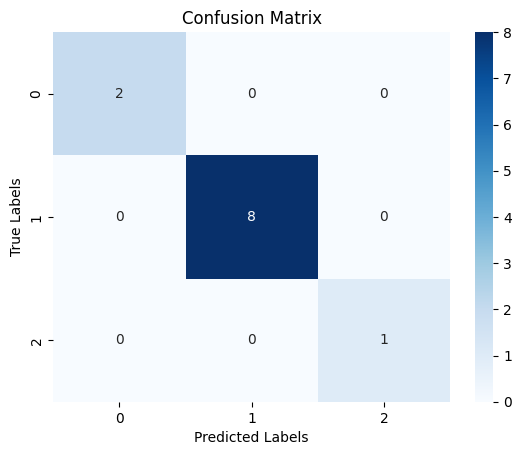

In [11]:
#Evaluasi
from sklearn.metrics import confusion_matrix
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [12]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred)) #evaluasi hasil

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         1

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11



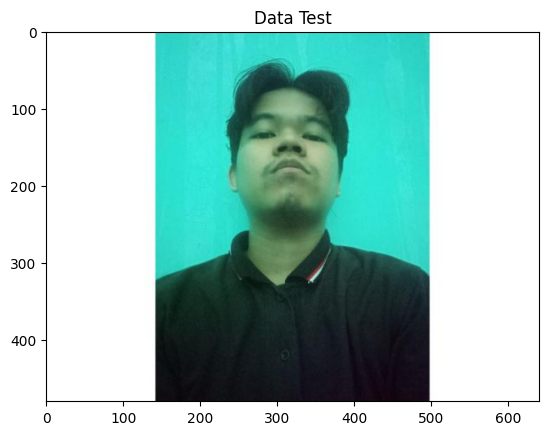

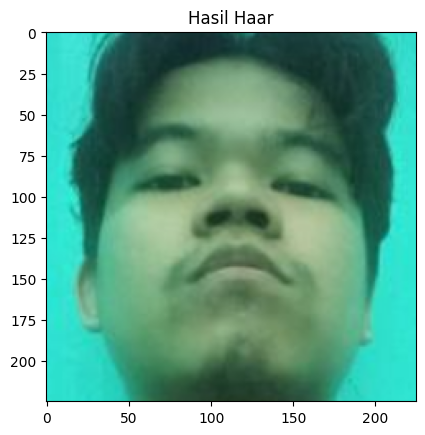

 jumlah keypoint terbentuk 71


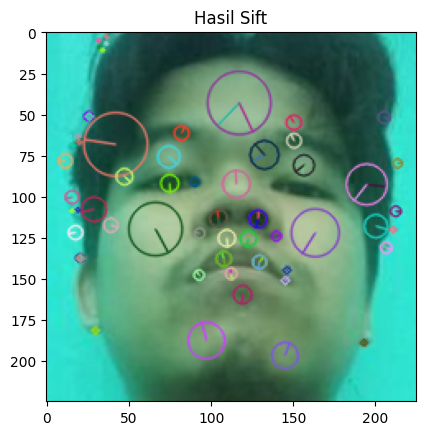

(1, 70)
ukuran data test (1, 70)
nilai probabilitas [[0. 1. 0.]]
farrel = 0.0%
izul = 100.0%
rano = 0.0%
prediksinya: ['izul']
The predicted image is : [1] -> ['izul']


In [13]:
#Test Gambar 

import matplotlib.pyplot as plt
import cv2
import os
import os.path
import numpy as np  

url= 'dataset_wajah/izul/izul (50).jpg'
img=cv2.imread(url)
plt.figure()
plt.title("Data Test")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

#pastikan langkah preprocessing yang dilakukan sama dengan data train
status,haarnya=haar(img)
img_resize = cv2.resize(haarnya,(225,225))
#tampilkan hasil
plt.figure()
plt.title("Hasil Haar")
plt.imshow(cv2.cvtColor(img_resize, cv2.COLOR_BGR2RGB))
plt.show()


plt.figure()
plt.title("Hasil Sift")
# sift = cv2.SIFT_create()
sift = cv2.SIFT_create(nfeatures=70, nOctaveLayers=9, contrastThreshold=0.03, edgeThreshold=10, sigma=1.6)
kpts, des = sift.detectAndCompute(img_resize, None)
# Marking the keypoint on the image using circles
img=cv2.drawKeypoints(img_resize, kpts , img_resize ,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
print(f" jumlah keypoint terbentuk {len(kpts)}")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()


# bovw
#kmeans works only on float, so convert integers to float
descriptors_float = des.astype(float)  
# Perform k-means clustering and vector quantization
from scipy.cluster.vq import kmeans, vq
k = 70  #dari total 500 diambil hanya 200
voc, variance = kmeans(obs=descriptors_float, k_or_guess=k, iter=5) 
# Calculate the histogram of features and represent them as vector
#vq Assigns codes from a code book to observations.
im_features = np.zeros((1, k), "float32")
for i in range(1):
    words, distance = vq(des,voc)
    for w in words:
        im_features[i][w] += 1
print(im_features.shape)

print(f"ukuran data test {im_features.shape}") #sama dengan input shape

# Mengecek hasil klasifikasi pada salah satu dataset
probability=best.predict_proba(im_features)
print(f"nilai probabilitas {probability}") #tampilkan nilai probabilitas tiap kelas



for ind,val in enumerate(label_dict): #mendapatkan nama kelas dan hasil akurasi
    print(f'{val} = {probability[0][ind]*100}%')
    
    
hasil = np.argmax(probability, axis=-1) #mendapatkan kelas dari probabilitas terbaik
key_found = [key for key, value in label_dict.items() if value == hasil] #dapatkan namanya
print(f"prediksinya: {key_found}")
print(f"The predicted image is : {str(hasil)} -> {key_found}")

In [14]:
#Simpan model

import pickle
pickle.dump(best, open('weight/model_haar_sift_knn.pkl', 'wb')) #simpan dalam file.pkl

In [15]:
#Testing Menggunakan Kamera secara langsung

import cv2
import os
import os.path
import numpy as np
from time import sleep
import pickle

def read_model(filename, path=""):
    with open(os.path.join(path, filename), 'rb') as in_name:
        model = pickle.load(in_name)
        return model
    

color = (255, 0, 0)
cap = cv2.VideoCapture(0) # 0 jika kamera
model = read_model("weight/model_haar_sift_knn.pkl", path="") #load model
label_dict = np.load('weight/label_knn.npy', allow_pickle=True).item() #load label


while (cap.isOpened()):
    ret , frame = cap.read() #baca vidio dengan looping gambar
    if ret:
        face_roi = []# Load Haar Cascade classifier for face detection
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        # Convert the image to grayscale (required for face detection)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect faces in the image using the face_cascade
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.5, minNeighbors=5)
        # Draw bounding boxes around the detected faces and display the image
        for (x, y, w, h) in faces:
            # Draw a rectangle around the detected face
            face_roi = frame[y:y+h, x:x+w]
            cv2.rectangle(frame, (x-5, y-5), (x + w+5, y + h+5), (0, 255, 0), 4)#beri rectangle dan beri overlap sebesar 5
            muka = cv2.resize(face_roi, (225,225), interpolation = cv2.INTER_AREA)#wajib sama dengan citra inputan trainer
            #sift
            sift = cv2.SIFT_create(nfeatures=500, nOctaveLayers=9, contrastThreshold=0.03, edgeThreshold=10, sigma=1.6)
            kpts, des = sift.detectAndCompute(muka, None)
            print(f" jumlah keypoint terbentuk {len(kpts)}")
            if(len(kpts) >= 200): #karna sistem akan akan menggunakan shape 200 minimal
                cv2.imshow("Haar",muka)
                # Marking the keypoint on the image using circles
                img=cv2.drawKeypoints(muka, kpts , muka ,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
                # bovw
                #kmeans works only on float, so convert integers to float
                descriptors_float = des.astype(float)  
                # Perform k-means clustering and vector quantization
                from scipy.cluster.vq import kmeans, vq
                k = 200  #dari total 500 diambil hanya 200
                voc, variance = kmeans(obs=descriptors_float, k_or_guess=k, iter=5) 
                # Calculate the histogram of features and represent them as vector
                #vq Assigns codes from a code book to observations.
                im_features = np.zeros((1, k), "float32")
                for i in range(1):
                    words, distance = vq(des,voc)
                    for w in words:
                        im_features[i][w] += 1
                
                cv2.imshow("Sift",img)
                prediksi= model.predict(im_features) #prediksi
                key_found = [key for key, value in label_dict.items() if value == prediksi] #dapatkan namanya
                cv2.putText(frame, f"Deteksi : {key_found[0]}", (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255),2)
        cv2.imshow("Video Original" , frame)
    else:
        print('no video')
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        continue

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)  

no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
n

no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
n

no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
n

no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
n

no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
n

no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
n

no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
n

no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
n

no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
n

no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video
no video


KeyboardInterrupt: 

In [17]:
#Testing menggunakan input video

import cv2
import os
import os.path
import numpy as np
from time import sleep
import pickle

def read_model(filename, path=""):
    with open(os.path.join(path, filename), 'rb') as in_name:
        model = pickle.load(in_name)
        return model
    

color = (255, 0, 0)
video_path = input("Masukkan path video: ")  # Meminta pengguna untuk memasukkan path video
cap = cv2.VideoCapture(video_path)  # Membaca video dari file yang ditentukan

model = read_model("weight/model_haar_sift_knn.pkl", path="") #load model
label_dict = np.load('weight/label_knn.npy', allow_pickle=True).item() #load label


while (cap.isOpened()):
    ret , frame = cap.read() #baca video dengan looping gambar
    if ret:
        face_roi = []# Load Haar Cascade classifier for face detection
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        # Convert the image to grayscale (required for face detection)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect faces in the image using the face_cascade
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.5, minNeighbors=5)
        # Draw bounding boxes around the detected faces and display the image
        for (x, y, w, h) in faces:
            # Draw a rectangle around the detected face
            face_roi = frame[y:y+h, x:x+w]
            cv2.rectangle(frame, (x-5, y-5), (x + w+5, y + h+5), (0, 255, 0), 4)#beri rectangle dan beri overlap sebesar 5
            muka = cv2.resize(face_roi, (225,225), interpolation = cv2.INTER_AREA)#wajib sama dengan citra inputan trainer
            #sift
            sift = cv2.SIFT_create(nfeatures=500, nOctaveLayers=9, contrastThreshold=0.03, edgeThreshold=10, sigma=1.6)
            kpts, des = sift.detectAndCompute(muka, None)
            print(f" jumlah keypoint terbentuk {len(kpts)}")
            if(len(kpts) >= 200): #karna sistem akan akan menggunakan shape 200 minimal
                cv2.imshow("Haar",muka)
                # Marking the keypoint on the image using circles
                img=cv2.drawKeypoints(muka, kpts , muka ,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
                # bovw
                #kmeans works only on float, so convert integers to float
                descriptors_float = des.astype(float)  
                # Perform k-means clustering and vector quantization
                from scipy.cluster.vq import kmeans, vq
                k = 70  #dari total 500 diambil hanya 200
                voc, variance = kmeans(obs=descriptors_float, k_or_guess=k, iter=5) 
                # Calculate the histogram of features and represent them as vector
                #vq Assigns codes from a code book to observations.
                im_features = np.zeros((1, k), "float32")
                for i in range(1):
                    words, distance = vq(des,voc)
                    for w in words:
                        im_features[i][w] += 1
                
                cv2.imshow("Sift",img)
                prediksi= model.predict(im_features) #prediksi
                key_found = [key for key, value in label_dict.items() if value == prediksi] #dapatkan namanya
                cv2.putText(frame, f"Deteksi : {key_found[0]}", (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255),2)
        cv2.imshow("Video Original" , frame)
    else:
        print('no video')
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        continue

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

Masukkan path video: C:\Users\Acer\Videos\WhatsApp Video 2023-11-08 at 00.30.13.mp4
 jumlah keypoint terbentuk 43
 jumlah keypoint terbentuk 53
 jumlah keypoint terbentuk 54
 jumlah keypoint terbentuk 34
 jumlah keypoint terbentuk 75
 jumlah keypoint terbentuk 87
 jumlah keypoint terbentuk 198
 jumlah keypoint terbentuk 141
 jumlah keypoint terbentuk 271
 jumlah keypoint terbentuk 141
 jumlah keypoint terbentuk 75
 jumlah keypoint terbentuk 42
 jumlah keypoint terbentuk 127
 jumlah keypoint terbentuk 49
 jumlah keypoint terbentuk 138
no video
 jumlah keypoint terbentuk 43
 jumlah keypoint terbentuk 53
 jumlah keypoint terbentuk 54
 jumlah keypoint terbentuk 34
 jumlah keypoint terbentuk 75
 jumlah keypoint terbentuk 87
 jumlah keypoint terbentuk 198
 jumlah keypoint terbentuk 141
 jumlah keypoint terbentuk 271
 jumlah keypoint terbentuk 141
 jumlah keypoint terbentuk 75
 jumlah keypoint terbentuk 42
 jumlah keypoint terbentuk 127
 jumlah keypoint terbentuk 49
 jumlah keypoint terbentuk

 jumlah keypoint terbentuk 141
 jumlah keypoint terbentuk 271
 jumlah keypoint terbentuk 141
 jumlah keypoint terbentuk 75
 jumlah keypoint terbentuk 42
 jumlah keypoint terbentuk 127
 jumlah keypoint terbentuk 49
 jumlah keypoint terbentuk 138
no video
 jumlah keypoint terbentuk 43
 jumlah keypoint terbentuk 53
 jumlah keypoint terbentuk 54
 jumlah keypoint terbentuk 34
 jumlah keypoint terbentuk 75
 jumlah keypoint terbentuk 87
 jumlah keypoint terbentuk 198
 jumlah keypoint terbentuk 141
 jumlah keypoint terbentuk 271
 jumlah keypoint terbentuk 141
 jumlah keypoint terbentuk 75
 jumlah keypoint terbentuk 42
 jumlah keypoint terbentuk 127
 jumlah keypoint terbentuk 49
 jumlah keypoint terbentuk 138
no video
 jumlah keypoint terbentuk 43
 jumlah keypoint terbentuk 53
 jumlah keypoint terbentuk 54
 jumlah keypoint terbentuk 34
 jumlah keypoint terbentuk 75
 jumlah keypoint terbentuk 87
 jumlah keypoint terbentuk 198
 jumlah keypoint terbentuk 141
 jumlah keypoint terbentuk 271
 jumlah 

 jumlah keypoint terbentuk 34
 jumlah keypoint terbentuk 75
 jumlah keypoint terbentuk 87
 jumlah keypoint terbentuk 198
 jumlah keypoint terbentuk 141
 jumlah keypoint terbentuk 271
 jumlah keypoint terbentuk 141
 jumlah keypoint terbentuk 75
 jumlah keypoint terbentuk 42
 jumlah keypoint terbentuk 127
 jumlah keypoint terbentuk 49
 jumlah keypoint terbentuk 138
no video
 jumlah keypoint terbentuk 43
 jumlah keypoint terbentuk 53
 jumlah keypoint terbentuk 54
 jumlah keypoint terbentuk 34
 jumlah keypoint terbentuk 75
 jumlah keypoint terbentuk 87
 jumlah keypoint terbentuk 198
 jumlah keypoint terbentuk 141
 jumlah keypoint terbentuk 271
 jumlah keypoint terbentuk 141
 jumlah keypoint terbentuk 75
 jumlah keypoint terbentuk 42
 jumlah keypoint terbentuk 127
 jumlah keypoint terbentuk 49
 jumlah keypoint terbentuk 138
no video
 jumlah keypoint terbentuk 43
 jumlah keypoint terbentuk 53
 jumlah keypoint terbentuk 54
 jumlah keypoint terbentuk 34
 jumlah keypoint terbentuk 75
 jumlah ke

KeyboardInterrupt: 